**SECCIÓ 3: Mètodes espectrals**  
**Exemple 3.6: Equació de Korteweg-de Vries**

En aquest repositori es presenta la simulació emprada per a l’equació de Korteweg-de Vries, **Exemple 3.6**, que correspon a la **Secció 3** del treball.


In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import numpy.polynomial.chebyshev as np_cheb
from scipy.integrate import solve_ivp
from scipy.linalg import solve_banded
from math import pi
import matplotlib.pylab as pylab
from scipy.special import eval_chebyt
from scipy.linalg import expm
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad


params = {
    'legend.fontsize': 10,
    'legend.loc': 'best',
    'figure.figsize': (14, 5),
    'lines.markerfacecolor': 'none',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'grid.alpha': 0.6,
    "text.usetex": True,                       
    "font.family": "serif",                    
    "font.serif": ["Computer Modern Roman"],   
    "text.latex.preamble": r"\usepackage{amsmath}" 
}

In [ ]:
# --------------------------
# Regla de 3/2
# --------------------------
def nonlinear_term_uv(u_hat, v_hat, N):
    M = (3 * N) // 2 #N even!

    u_hat_pad = np.zeros(M, dtype=complex)
    v_hat_pad = np.zeros(M, dtype=complex)
    
    u_hat_pad[:N//2] = u_hat[:N//2]  
    u_hat_pad[-(N//2):] = u_hat[-(N//2):] 
    
    v_hat_pad[:N//2] = v_hat[:N//2]  
    v_hat_pad[-(N//2):] = v_hat[-(N//2):] 

    u_pad = np.fft.ifft(u_hat_pad).real * M / N  
    v_pad = np.fft.ifft(v_hat_pad).real * M / N 

    nonlinear_term_pad = np.fft.fft(u_pad * v_pad) * N / M

    nonlinear_term = np.zeros(N, dtype=complex)
    nonlinear_term[:N//2] = nonlinear_term_pad[:N//2]  
    nonlinear_term[-(N//2):] = nonlinear_term_pad[-(N//2):]  

    return nonlinear_term 

# --------------------------
# Terme no-lineal
# --------------------------
def f(U, k): 
    return - 3j * k * np.fft.fft(np.real(np.fft.ifft(U))**2)

def fpadd(U, k): 
    return - 3j * k * nonlinear_term_uv(U, U, N)

In [ ]:
#Parametres
L = 20 #domini
N = 128 #nombre harmonics
tmax = 20 #temps de simulacio
delta_t = 0.01 #pas de temps
nmax = round(tmax / delta_t)
q = 10 #densitat de fotogrames

#Condicio inicial 
x = np.linspace(-L, L, N, endpoint = False)
k = np.fft.fftfreq(N, d=(2*L / N)) * (2 * np.pi)
u = 0.5 * (1 / np.cosh(np.sqrt(1) / 2 * (x)))**2 

# --------------------------
# Solucions cada cas
# --------------------------

#Euler
u_list = []
U = np.fft.fft(u) 
for n in range(nmax):
    U = np.exp(1j * k**3 * delta_t)*(U -  3j * k * np.fft.fft(np.real(np.fft.ifft(U))**2)*delta_t)

    if n % q == 0: 
        u_list.append(np.real(np.fft.ifft(U)))       
u_final = np.real(np.fft.ifft(U))

#Euler + 3/2
u_list_padd = []
U = np.fft.fft(u)
for n in range(nmax):
    U = np.exp(1j * k**3 * delta_t)*(U -  3j * k * nonlinear_term_uv(U, U, N) *delta_t)

    if n % q == 0: 
        u_list_padd.append(np.real(np.fft.ifft(U)))
u_final_padd = np.real(np.fft.ifft(U))

#RK2
u_list_RK2 = []
U = np.fft.fft(u)
for n in range(nmax):
    k1 = f(U, k)
    k2 = f(U + 0.5 * delta_t * k1, k)

    U = np.exp(1j * k**3 * delta_t)*(U + delta_t * k2)

    if n % q == 0:
        u_list_RK2.append(np.real(np.fft.ifft(U)))
u_final_RK2 = np.real(np.fft.ifft(U))

#RK2 + 3/2
u_list_RK2_padd = []
U = np.fft.fft(u)
for n in range(nmax):
    k1 = fpadd(U, k)
    k2 = fpadd(U + 0.5 * delta_t * k1, k)

    U = np.exp(1j * k**3 * delta_t)*(U + delta_t * k2)

    if n % q == 0:
        u_list_RK2_padd.append(np.real(np.fft.ifft(U)))
u_final_RK2_padd = np.real(np.fft.ifft(U))

#RK4
u_list_RK4 = []
U = np.fft.fft(u)
for n in range(nmax):
    k1 = f(U, k)
    k2 = f(U + 1/2 * delta_t * k1, k)
    k3 = f(U + 1/2 * delta_t * k2, k)
    k4 = f(U + delta_t * k3, k)

    U = np.exp(1j * k**3 * delta_t)*(U + 1/6 * delta_t * (k1 + 2*k2 + 2*k3 + k4))    
    
    if n % q == 0: 
        u_list_RK4.append(np.real(np.fft.ifft(U)))
u_final_RK4 = np.real(np.fft.ifft(U))

#RK4 + 3/2
u_list_RK4_padd = []
U = np.fft.fft(u)
for n in range(nmax):
    k1 = fpadd(U, k)
    k2 = fpadd(U + 1/2 * delta_t * k1, k)
    k3 = fpadd(U + 1/2 * delta_t * k2, k)
    k4 = fpadd(U + delta_t * k3, k)

    U = np.exp(1j * k**3 * delta_t)*(U + 1/6 * delta_t * (k1 + 2*k2 + 2*k3 + k4))  
    
    if n % q == 0: 
        u_list_RK4_padd.append(np.real(np.fft.ifft(U)))
u_final_RK4 = np.real(np.fft.ifft(U))

Iterations: 2000


C:\Users\guill\AppData\Local\Temp\ipykernel_6360\1303774538.py:32: RuntimeWarning: overflow encountered in square
  U = np.exp(1j * k**3 * delta_t)*(U -  3j * k * np.fft.fft(np.real(np.fft.ifft(U))**2)*delta_t)
C:\Users\guill\AppData\Local\Temp\ipykernel_6360\1303774538.py:32: RuntimeWarning: invalid value encountered in multiply
  U = np.exp(1j * k**3 * delta_t)*(U -  3j * k * np.fft.fft(np.real(np.fft.ifft(U))**2)*delta_t)
C:\Users\guill\AppData\Local\Temp\ipykernel_6360\1303774538.py:24: RuntimeWarning: overflow encountered in square
  return - 3j * k * np.fft.fft(np.real(np.fft.ifft(U))**2)
C:\Users\guill\AppData\Local\Temp\ipykernel_6360\1303774538.py:24: RuntimeWarning: invalid value encountered in multiply
  return - 3j * k * np.fft.fft(np.real(np.fft.ifft(U))**2)
C:\Users\guill\AppData\Local\Temp\ipykernel_6360\1303774538.py:74: RuntimeWarning: overflow encountered in square
  return - 3j * k * np.fft.fft(np.real(np.fft.ifft(U))**2)
C:\Users\guill\AppData\Local\Temp\ipykernel_6

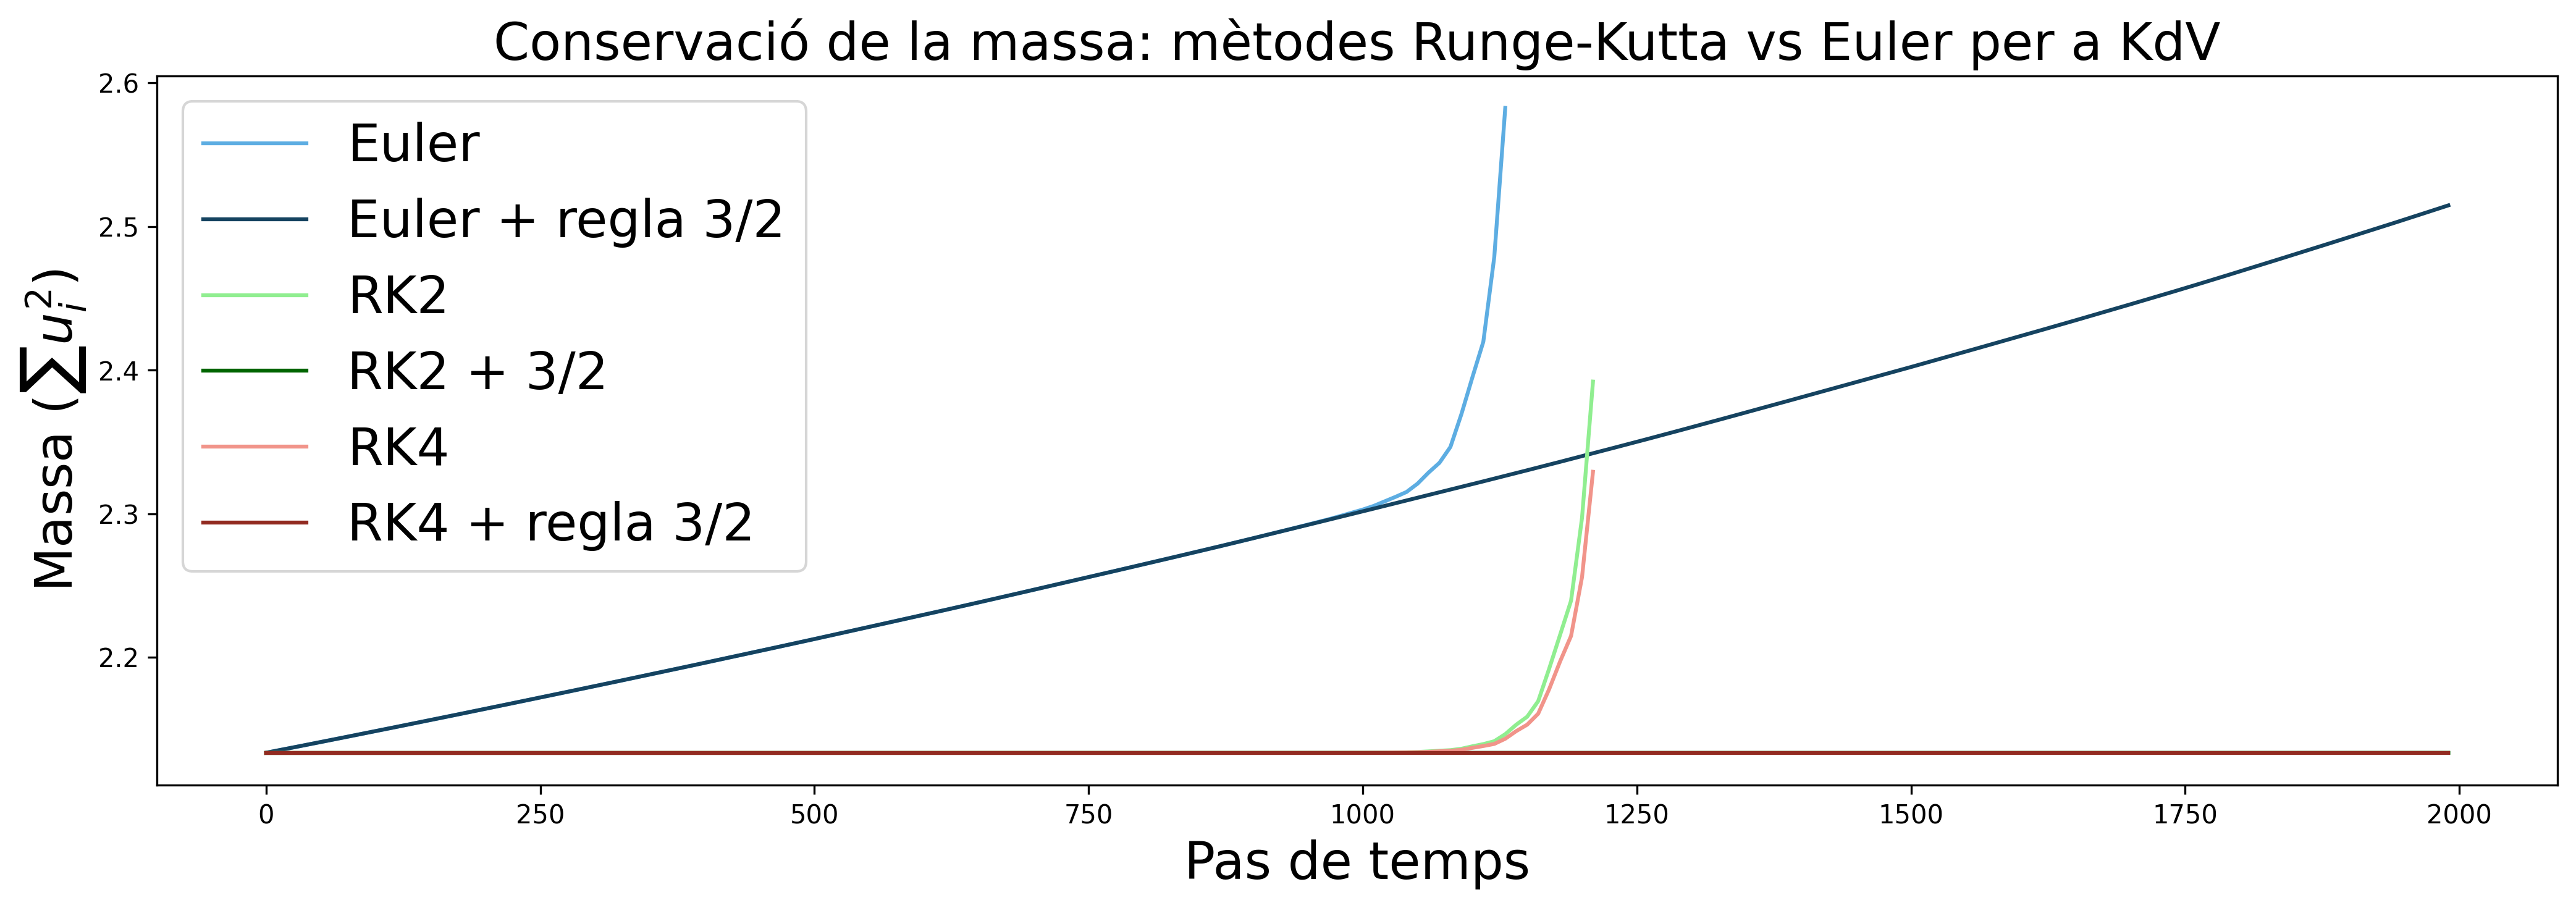

In [ ]:
# --------------------------
# Grafica massa en funcio del temps 
# --------------------------

timesteps = np.arange(len(u_list))
mass_u_list = np.array([np.sum(u**2) for u in u_list])
mass_u_list_padd = np.array([np.sum(u**2) for u in u_list_padd])
mass_u_list_RK2 = np.array([np.sum(u**2) for u in u_list_RK2])
mass_u_list_RK2_padd = np.array([np.sum(u**2) for u in u_list_RK2_padd])
mass_u_list_RK4 = np.array([np.sum(u**2) for u in u_list_RK4])
mass_u_list_RK4_padd = np.array([np.sum(u**2) for u in u_list_RK4_padd])


blue1 = '#5dade2'
blue2  = '#154360'
red1  = '#f1948a'
red2   = '#922b21'
green1 = '#90ee90'
green2  = '#006400'

plt.figure(figsize = (14,5), dpi=300)
plt.title(f'Conservació de la massa: mètodes Runge-Kutta vs Euler per a KdV', fontsize=20)
N1 = int(0.575*len(mass_u_list_RK4_padd))
N2 = int(len(mass_u_list_RK4_padd))
N3 =  int(0.61*len(mass_u_list_RK4_padd))
N4 = len(mass_u_list_RK4_padd)
N5 =  int(0.61*len(mass_u_list_RK4_padd))
N6 = len(mass_u_list_RK4_padd)
plt.plot(timesteps[0:N1]*q, mass_u_list[0:N1], label="Euler", color=blue1)
plt.plot(timesteps[0:N2]*q, mass_u_list_padd[0:N2], label="Euler + regla 3/2", color=blue2)
plt.plot(timesteps[0:N3]*q, mass_u_list_RK2[0:N3], label="RK2", color=green1)
plt.plot(timesteps[0:N4]*q, mass_u_list_RK2_padd[0:N4], label="RK2 + 3/2", color=green2)
plt.plot(timesteps[0:N5]*q, mass_u_list_RK4[0:N5], label="RK4", color=red1)
plt.plot(timesteps[0:N6]*q, mass_u_list_RK4_padd[0:N6], label="RK4 + regla 3/2", color=red2)

plt.xlabel("Pas de temps", fontsize=20)
plt.ylabel("Massa ($\\sum u_i^2$)", fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()